Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel
from gluonts.time_feature import get_lags_for_frequency, time_features_from_frequency_str

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load dataset and prepare df

In [2]:
import pandas as pd

# Load the dataset
file_path = '../data/WHO-COVID-19-global-data.csv'
df = pd.read_csv(file_path)[['Date_reported', 'Cumulative_deaths', 'Country_code']]
# We are interested in the 'Cumulative_deathscolumn and the 'Date_reported' column which we will index by
df['Date_reported'] = pd.to_datetime(df['Date_reported'])
df['Cumulative_deaths'] = df['Cumulative_deaths'].fillna(0)
df.iloc[df['Cumulative_deaths'].idxmax()]

Date_reported        2023-10-10 00:00:00
Cumulative_deaths                1138309
Country_code                          US
Name: 319358, dtype: object

In [3]:
pivot_df = df.pivot_table(index='Date_reported', columns='Country_code', values='Cumulative_deaths')

# If you need to flatten the columns (remove the multi-index in columns), you can do:
# pivot_df.columns = pivot_df.columns.get_level_values(0)  # This line might not be necessary

# If you want to turn the wide format back to long format after filling missing values:
# df = pivot_df.stack().reset_index(name='Cumulative_deaths')
from datetime import datetime

# Rename 'index' back to 'Date_reported'eported
df.rename(columns={'index': 'Date_reported'}, inplace=True)
df['Date_reported'] = pd.to_datetime(df['Date_reported']).dt.date
unique_dates = df['Date_reported'].unique()
df.set_index('Date_reported', inplace=True)
# df = df[df.index>=datetime.strptime('2020-01-22', '%Y-%m-%d').date()]
len(df.index)

333459

In [4]:
unique_dates = df.index.unique()
unique_dates

Index([2020-01-03, 2020-01-04, 2020-01-05, 2020-01-06, 2020-01-07, 2020-01-08,
       2020-01-09, 2020-01-10, 2020-01-11, 2020-01-12,
       ...
       2023-10-31, 2023-11-01, 2023-11-02, 2023-11-03, 2023-11-04, 2023-11-05,
       2023-11-06, 2023-11-07, 2023-11-08, 2023-11-09],
      dtype='object', name='Date_reported', length=1407)

In [5]:
df_train = df[df.index < unique_dates[-60]]
df_validation = df[df.index < unique_dates[-30]]
df_test = df

In [6]:
from gluonts.dataset.pandas import PandasDataset

ds_train = PandasDataset.from_long_dataframe(df_train, target='Cumulative_deaths', item_id='Country_code')
ds_validation = PandasDataset.from_long_dataframe(df_validation, target='Cumulative_deaths', item_id='Country_code')
ds_test = PandasDataset.from_long_dataframe(df_test, target='Cumulative_deaths', item_id='Country_code')

/home/samuell/.local/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [7]:
class ProcessStartField():
    ts_id = 0
    
    def __call__(self, data):
        data["start"] = data["start"].to_timestamp()
        data["feat_static_cat"] = [self.ts_id]
        data["feat_dynamic_real"] = None
        # data["item_id"] = f"T{self.ts_id+1}"
        self.ts_id += 1
        
        return data

In [8]:
from gluonts.itertools import Map

process_start = ProcessStartField()
process_start.ts_id = 0
list_ds_train = list(Map(process_start, ds_train))
process_start.ts_id = 0
list_ds_validation = list(Map(process_start, ds_validation))
process_start.ts_id = 0
list_ds_test = list(Map(process_start, ds_test))

In [9]:
from datasets import Dataset, Features, Value, Sequence

features  = Features(
    {    
        "start": Value("timestamp[s]"),
        "target": Sequence(Value("float32")),
        "feat_static_cat": Sequence(Value("uint64")),
        # "feat_static_real":  Sequence(Value("float32")),
        "feat_dynamic_real": Sequence(Sequence(Value("uint64"))),
        # "feat_dynamic_cat": Sequence(Sequence(Value("uint64"))),
        "item_id": Value("string"),
    }
)

In [10]:
train_dataset = Dataset.from_list(list_ds_train, features=features)
validation_dataset = Dataset.from_list(list_ds_validation, features=features)
test_dataset = Dataset.from_list(list_ds_test, features=features)

In [11]:
from datasets import DatasetDict

dataset = DatasetDict({"train":train_dataset, "validation": validation_dataset, "test":test_dataset})
df_dataset = pd.DataFrame(dataset["train"])
df_dataset

,start,target,item_id,feat_static_cat,feat_dynamic_real
0,2020-01-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",,[0],None
1,2020-01-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",AD,[1],None
2,2020-01-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",AE,[2],None
3,2020-01-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",AF,[3],None
4,2020-01-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",AG,[4],None
...,...,...,...,...,...
231,2020-01-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",YE,[231],None
232,2020-01-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",YT,[232],None
233,2020-01-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ZA,[233],None
234,2020-01-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ZM,[234],None


In [12]:

# from datasets import load_dataset
# dataset = load_dataset("monash_tsf", "covid_deaths")
# df_dataset = pd.DataFrame(dataset["train"])
# df_dataset

In [13]:
train_example = dataset['train'][0]
train_example.keys()
print(train_example['start'])
print(train_example['target'])

2020-01-03 00:00:00
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 4.0, 4.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0

In [14]:
train_example.keys()


dict_keys(['start', 'target', 'item_id', 'feat_static_cat', 'feat_dynamic_real'])

In [15]:
print(len(dataset['train'][0]['target']))
print(len(dataset['validation'][0]['target']))
print(len(dataset['test'][0]['target']))

1347
1377
1407


In [16]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]
print(len(train_dataset))

236


In [17]:
validation_example = dataset['validation'][0]
validation_example.keys()

dict_keys(['start', 'target', 'item_id', 'feat_static_cat', 'feat_dynamic_real'])

In [18]:
freq = "D"
prediction_length = 30
assert len(train_example["target"]) + prediction_length == len(
    validation_example["target"]
)

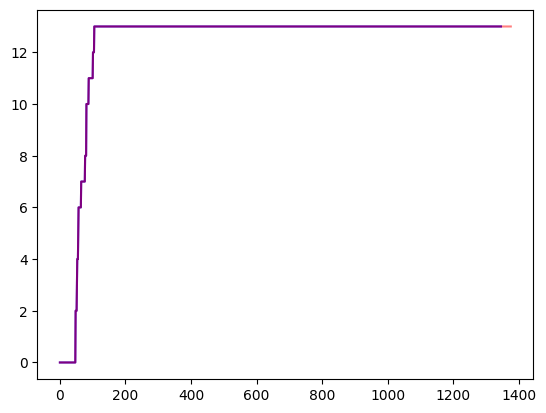

In [19]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example["target"], color="blue")
axes.plot(validation_example["target"], color="red", alpha=0.5)

plt.show()


In [20]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [21]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch


In [22]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))


In [23]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)



[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]


In [24]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)



[<function day_of_week at 0x7f4a417f91b0>, <function day_of_month at 0x7f4a417f92d0>, <function day_of_year at 0x7f4a417f93f0>]


In [25]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each of the 366 possible values:
    embedding_dimension=[2],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [26]:
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)


In [27]:
from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [28]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [29]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [30]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [31]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [32]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 1153, 4]) torch.FloatTensor
past_values torch.Size([256, 1153]) torch.FloatTensor
past_observed_mask torch.Size([256, 1153]) torch.FloatTensor
future_time_features torch.Size([256, 30, 4]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.LongTensor
future_values torch.Size([256, 30]) torch.FloatTensor
future_observed_mask torch.Size([256, 30]) torch.FloatTensor


In [33]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)


{'weight': Parameter containing:
tensor([[ 3.0039e-02,  2.3096e-02],
        [ 3.7126e-03,  2.7430e-03],
        [ 7.3763e-03, -3.0521e-02],
        [-2.4824e-02, -3.6407e-04],
        [ 5.0864e-03,  1.2880e-02],
        [-1.1005e-02,  3.0253e-02],
        [-1.0963e-02, -7.6476e-03],
        [-4.2769e-03, -1.0596e-02],
        [-2.6720e-02, -2.8916e-02],
        [ 2.1281e-03,  1.0454e-02],
        [ 1.1704e-02, -3.0137e-02],
        [ 4.0327e-02, -7.5560e-03],
        [-4.2951e-03, -6.6596e-03],
        [-3.3128e-02, -5.3202e-03],
        [-1.1449e-02, -3.3554e-02],
        [-1.8820e-02,  3.8807e-02],
        [ 4.1973e-02,  5.0936e-03],
        [ 2.3917e-02, -3.5049e-02],
        [ 2.0738e-02,  2.4456e-02],
        [-2.4561e-02,  3.2693e-02],
        [ 1.1651e-02,  1.0587e-02],
        [-1.3799e-02,  3.7724e-03],
        [-1.6971e-02,  6.0251e-03],
        [ 3.5695e-02,  4.9657e-02],
        [-2.0898e-02,  3.4609e-02],
        [ 5.7795e-03, -2.6189e-02],
        [ 4.1375e-04,  1.3870e-

In [34]:
print("Loss:", outputs.loss.item())

Loss: 5.860838890075684


In [35]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(1):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())


{'weight': Parameter containing:
tensor([[ 3.0039e-02,  2.3096e-02],
        [ 3.7126e-03,  2.7430e-03],
        [ 7.3763e-03, -3.0521e-02],
        [-2.4824e-02, -3.6407e-04],
        [ 5.0864e-03,  1.2880e-02],
        [-1.1005e-02,  3.0253e-02],
        [-1.0963e-02, -7.6476e-03],
        [-4.2769e-03, -1.0596e-02],
        [-2.6720e-02, -2.8916e-02],
        [ 2.1281e-03,  1.0454e-02],
        [ 1.1704e-02, -3.0137e-02],
        [ 4.0327e-02, -7.5560e-03],
        [-4.2951e-03, -6.6596e-03],
        [-3.3128e-02, -5.3202e-03],
        [-1.1449e-02, -3.3554e-02],
        [-1.8820e-02,  3.8807e-02],
        [ 4.1973e-02,  5.0936e-03],
        [ 2.3917e-02, -3.5049e-02],
        [ 2.0738e-02,  2.4456e-02],
        [-2.4561e-02,  3.2693e-02],
        [ 1.1651e-02,  1.0587e-02],
        [-1.3799e-02,  3.7724e-03],
        [-1.6971e-02,  6.0251e-03],
        [ 3.5695e-02,  4.9657e-02],
        [-2.0898e-02,  3.4609e-02],
        [ 5.7795e-03, -2.6189e-02],
        [ 4.1375e-04,  1.3870e-

In [36]:
model.eval()

forecasts = []

for batch in test_dataloader:
    # raise KeyError(batch)
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())


{'weight': Parameter containing:
tensor([[ 5.0059e-02,  5.5065e-03],
        [ 2.7939e-02, -1.8451e-02],
        [ 3.8489e-02, -5.8284e-02],
        [-5.7860e-03, -1.8847e-02],
        [ 1.9382e-02, -1.4490e-03],
        [-3.1575e-03,  2.6561e-02],
        [ 2.9004e-03, -2.3753e-02],
        [ 2.0406e-02, -3.7484e-02],
        [-9.1344e-03, -4.3940e-02],
        [ 1.5519e-02, -5.1835e-03],
        [ 1.7879e-02, -3.4764e-02],
        [ 6.3325e-02, -2.8201e-02],
        [ 5.0507e-03, -1.6068e-02],
        [-9.0512e-03, -2.7919e-02],
        [-8.5361e-04, -4.3431e-02],
        [-2.1655e-03,  2.0877e-02],
        [ 6.2832e-02, -1.5228e-02],
        [ 4.3383e-02, -5.4256e-02],
        [ 5.5110e-02, -6.2802e-03],
        [-8.6395e-03,  1.8638e-02],
        [ 2.3249e-02, -1.0323e-03],
        [ 2.2267e-03, -1.0354e-02],
        [-8.0604e-03, -1.6253e-03],
        [ 5.1290e-02,  3.4152e-02],
        [ 1.3157e-03,  1.9917e-02],
        [ 3.0391e-02, -4.7181e-02],
        [ 9.7477e-03,  5.2434e-

In [37]:
forecasts[0].shape

(64, 100, 30)

In [38]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(236, 100, 30)


In [39]:
from evaluate import load
from gluonts.time_feature import get_seasonality
import math
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")
mse_metric = load("evaluate-metric/mse")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
mse_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])
    
    mse = mse_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    mse_metrics.append(math.sqrt(mse["mse"]))


In [40]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 2263.0029107311157


In [41]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 0.1275842981507327


In [42]:
print(f"MSE: {np.mean(mse_metrics)}")

MSE: 1609.7992850170635


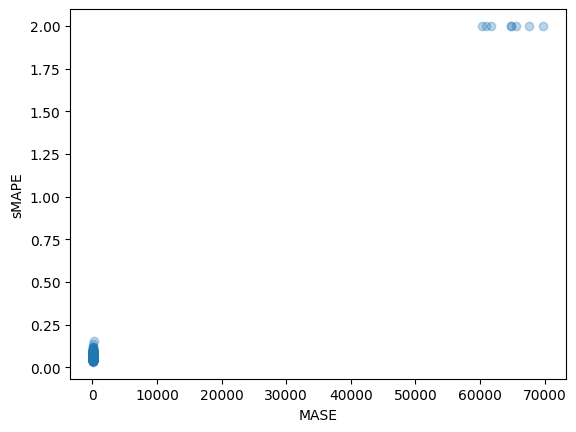

In [43]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [44]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()


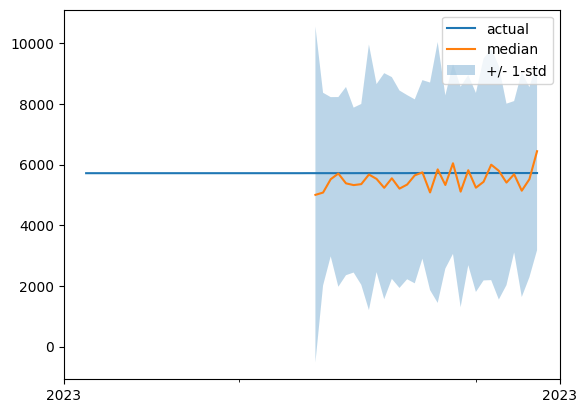

In [47]:
plot(235)


In [ ]:
forecasts